In [4]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [7]:
CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  #converts the audio to string
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)  # makes a tensor of wav file which can be plotted with single channel and the sample rate
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)  # (134000, 1) to remove this 1
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)  #making it 64 so to support the format
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [9]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)  # orange
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)  # blue

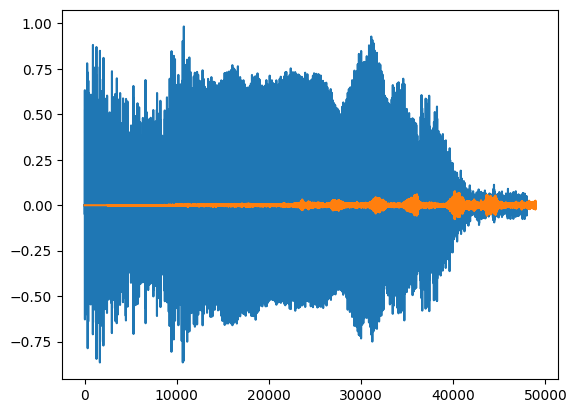

In [10]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [11]:
POS = os.path.join('Data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('Data', 'Parsed_Not_Capuchinbird_Clips')

In [12]:
# set of dataset in form of strings in tensorflow format
# this loads all the positive and negative audio file path to the pos and neg variables
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [13]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))  #marking all the pos files with 1 --> ('filespath', 1)
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))) #marking all the neg files with 0 --> ('filepath', 0)
data = positives.concatenate(negatives)  # then we combines all the data

In [ ]:
#we are converting all the pos audio to wave form
lengths = []
for file in os.listdir(os.path.join('Data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('Data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [15]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [16]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [17]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [18]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]    #As the average length is around 48k we will be taking the first 48k of the wav for the processing
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)    # this here is going to fill the data that is less then 48k with 0s at front
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)  # (1491, 257)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)     # (1491 , 257 , 1)  it added a channel which is needed for the convo nn - which now work as a gray scale image
    return spectrogram, label

In [19]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [20]:
spectrogram, label = preprocess(filepath, label)

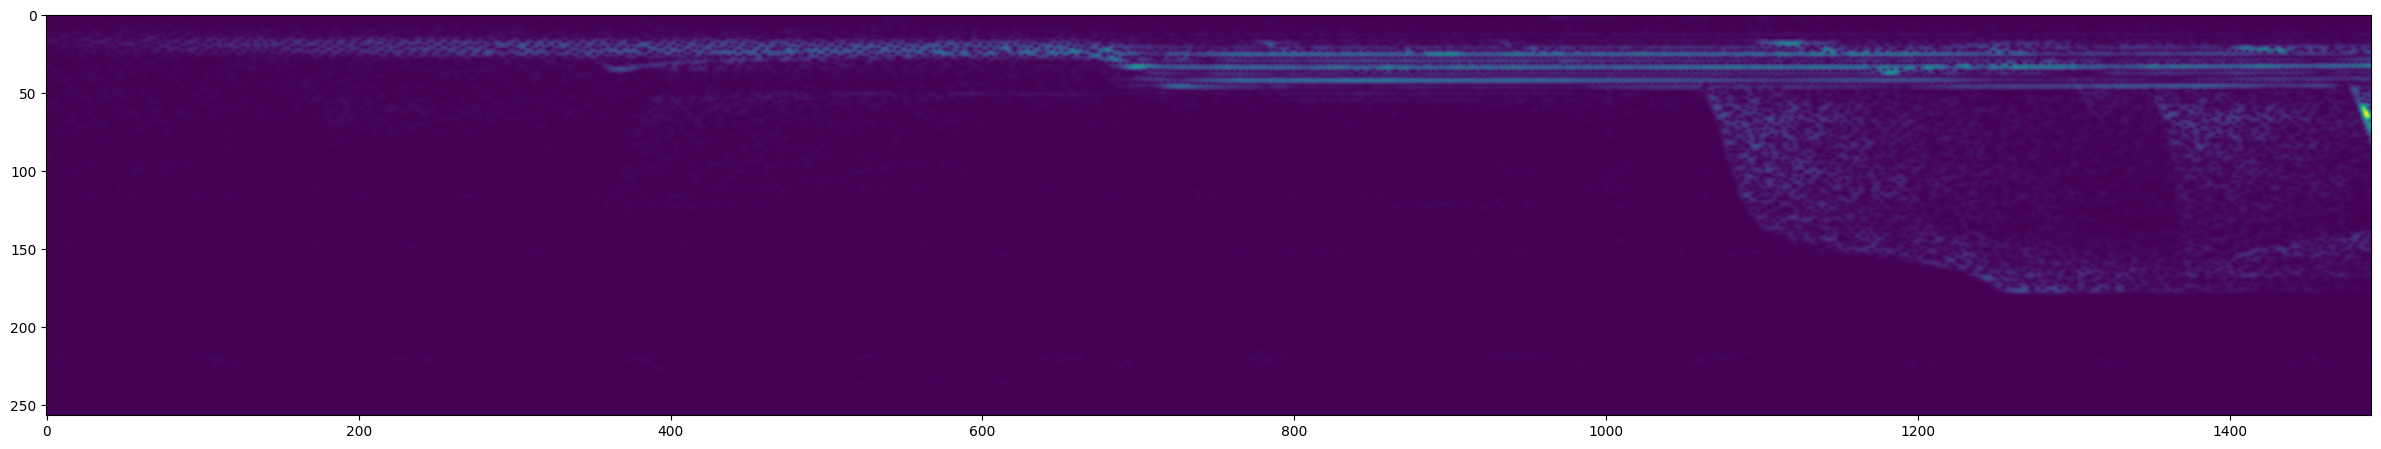

In [21]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)              # converting all the data into spectrogram
data = data.cache()                      # for faster loading of dataset by storing it in the memory
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)                  # it is like program counter, it stores the some of the previous batch in the backgroud while it process current batch as to minimize the waiting time

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 1491, 257, 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [27]:
model = Sequential()
model.add(Conv2D(1, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size =(2,2), strides =(2,2)))
model.add(Conv2D(1, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.Accuracy()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 1)      10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 1)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 1)       10        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 1)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23002)             0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
acc = model.evaluate(X_test, y_test)
acc

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content', 'drive', 'MyDrive', 'Research_paper_project', 'Data', 'Forest Recordings', 'recording_00.mp3')
# /content/drive/MyDrive/Research_paper_project/Data/Forest Recordings/recording_00.mp3

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content', 'drive', 'MyDrive', 'Research_paper_project', 'Data', 'Forest Recordings')):
    FILEPATH = os.path.join('/content', 'drive', 'MyDrive', 'Research_paper_project', 'Data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])